In [75]:
!pip install hmmlearn

In [76]:
from hmmlearn import hmm

In [77]:
import pandas as pd
import numpy as np

# Grab Data

In [78]:
def grab_labelled_data(data_path, label_begins = 98): 
  labelled = pd.read_csv(data_path)
  label_begins = 98

  features = labelled.iloc[:, 2:label_begins] 
  labels = labelled.iloc[:, label_begins:]
  ids = labelled.iloc[:, :2]

  labels.columns = [x[10:] for x in labels.columns]

  features = features.join(ids)
  labels = labels.join(ids)

  features.columns.name = 'Time' 
  labels.columns.name = 'Time'

  features = features.pivot_table(index = ['Student ID', 'Date'])
  labels = labels.pivot_table(index = ['Student ID', 'Date'])

  features = pd.DataFrame(features.stack()).reset_index()
  labels = pd.DataFrame(labels.stack()).reset_index()

  time_stamps = features['Date'] + " " + features['Time']
  time_stamps = pd.to_datetime(time_stamps)

  features['Datetime'] = time_stamps
  labels['Datetime'] = time_stamps

  features = features.drop(columns = ['Date', 'Time'] ) 
  labels = labels.drop(columns = ['Date', 'Time'])

  features = features.pivot_table(index = ['Student ID', 'Datetime']) 
  labels = labels.pivot_table(index = ['Student ID', 'Datetime'])

  features.columns = ['Steps'] 
  labels.columns = ['Asleep']

  labelled_data = features.join(labels * 200)

  return labelled_data 

In [79]:
def grab_unlabelled_data(data_path): 
  unlabelled = pd.read_csv(data_path) 
  unlabelled = unlabelled.pivot_table(index = ['Student ID', 'Date'])
  unlabelled.columns.name = 'Time'
  unlabelled = pd.DataFrame(unlabelled.stack())
  unlabelled = unlabelled.reset_index()
  unlabelled['Datetime'] = pd.to_datetime(unlabelled['Date'] + ' ' + unlabelled['Time'])
  unlabelled = unlabelled.drop(columns = ['Date', 'Time'])
  unlabelled = unlabelled.pivot_table(index = ['Student ID', 'Datetime'])
  unlabelled.columns = ['Steps']

  return unlabelled 

In [80]:
unlabelled_data = grab_unlabelled_data('BMCM_steps.csv')

In [81]:
# unlabelled_data['Steps'] = unlabelled_data['Steps'].rolling(4).mean()

# Model Declaration

In [82]:
model = hmm.GMMHMM(n_components = 2, n_mix = 2, init_params = '', params = 'stmcw') 

In [83]:
model.startprob_ = np.array([0.64, 0.36])
model.transmat_ = np.array([[0.98, 0.02], 
                            [0.04, 0.96]])

In [84]:
model.means_ = np.array([[[4.023],
                          [0]],
                        [[1.291],
                          [3.097]]])

In [85]:
model.covars_ = np.array([[[2.157],
                            [0.0001]],
                          [[0.879],
                            [0.485]]])

In [86]:
model.weights_ = np.array([
                           [0.826, 0.174], 
                           [0.370, 0.630]
])

In [87]:
model.get_stationary_distribution()

array([0.66666667, 0.33333333])

In [88]:
# model_full = hmm.GMMHMM(n_components = 3, n_mix = 2, init_params = 'mcw', params = 'stmcw')

In [89]:
# model_full.startprob_ = np.array([0.64, 0.27, 0.09])
# model_full.transmat_ = np.array([[0.98, 0.02, 0], 
#                             [0.04, .72 ,.24],
#                             [0.04, .72,.24]])

# Model Training

In [90]:
unlabelled_data = unlabelled_data.dropna()

In [91]:
T = unlabelled_data.loc[100].shape[0]
lengths = [T for id in range(100,500)]

In [92]:
X = np.array(unlabelled_data['Steps']).reshape(-1, 1)
X = np.log(1 + X)

In [93]:
model.fit(X, lengths = lengths)

GMMHMM(algorithm='viterbi', covariance_type='diag',
       covars_prior=array([[[-1.5],
        [-1.5]],

       [[-1.5],
        [-1.5]]]),
       covars_weight=array([[[0.],
        [0.]],

       [[0.],
        [0.]]]),
       init_params='',
       means_prior=array([[[0.],
        [0.]],

       [[0.],
        [0.]]]),
       means_weight=array([[0., 0.],
       [0., 0.]]), min_covar=0.001,
       n_components=2, n_iter=10, n_mix=2, params='stmcw', random_state=None,
       startprob_prior=1.0, tol=0.01, transmat_prior=1.0, verbose=False,
       weights_prior=array([[1., 1.],
       [1., 1.]]))

In [ ]:
y = model.predict(X, lengths = lengths)

Degenerate mixture covariance


In [ ]:
Y = unlabelled_data
Y['Predictions'] = y

In [ ]:
Y.to_csv("HMM_Predictions_On_Unlabelled.csv")

In [ ]:
y.mean()

0.2870749327956989

# Model Testing

In [94]:
model.monitor_.converged

True

In [95]:
model.means_

array([[[3.96918713],
        [0.        ]],

       [[1.61478511],
        [3.11220671]]])

In [96]:
model.covars_

array([[[2.05167158],
        [0.        ]],

       [[0.37160051],
        [0.46510187]]])

In [97]:
model.weights_

array([[0.79220449, 0.20779551],
       [0.32670428, 0.67329572]])

In [98]:
model.transmat_

array([[0.95883136, 0.04116864],
       [0.09954796, 0.90045204]])

In [99]:
model.startprob_

array([0.58482724, 0.41517276])

In [100]:
model.get_stationary_distribution()

array([0.70743579, 0.29256421])

In [101]:
labelled_data = grab_labelled_data('BMCM_steps_sleep.csv')

In [102]:
T = labelled_data.loc[0].shape[0]
lengths = [T for id in range(0,100)] 

In [103]:
test_X = np.array(labelled_data['Steps']).reshape(-1,1)
test_X = np.log(1 + test_X)

In [104]:
y = model.predict(test_X, lengths = lengths)

Degenerate mixture covariance


In [105]:
labelled_data['Predictions'] = y

In [106]:
labelled_data['Asleep'] /= 200

In [107]:
labelled_data.to_csv("HMM_Predictions_On_Labelled.csv")

In [108]:
labelled_data['Predictions'] = y

In [109]:
labelled_data['Asleep'] /= 200

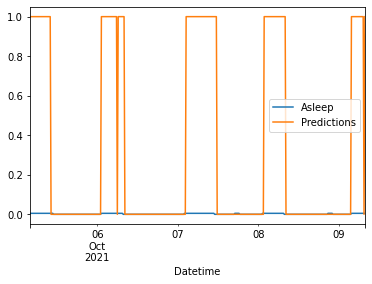

In [110]:
labelled_data[['Asleep', 'Predictions']].loc[0].iloc[400:800].plot()

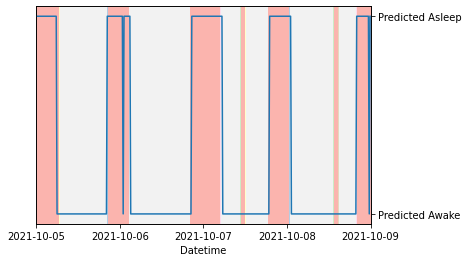

In [115]:
import matplotlib.pyplot as plt


f, ax = plt.subplots() 

ax2 = ax.twinx() 
labels = np.reshape(np.array(labelled_data['Asleep'])[400:800], (1,-1))
ax.imshow(1 - labels, aspect = 'auto', cmap = 'Pastel1')

ax2.plot(np.array(labelled_data['Predictions'])[400:800])

ax.set_xticks([100*x for x in range(0,5)])
ax.set_xticklabels([labelled_data.loc[0].iloc[400:801].index[100*i].date() for i in range(0,5)])

ax.set_yticks([])
ax2.set_yticks([0,1])
ax2.set_yticklabels(["Predicted Awake", "Predicted Asleep"])

ax.set_xlabel("Datetime") 

f.savefig("HMMPredictionAgainstLabel.png")

In [112]:
(labelled_data['Asleep'] == labelled_data['Predictions']).mean()

0.6369858870967742

In [113]:
labelled_data.loc[0].iloc[400:800].index

DatetimeIndex(['2021-10-05 04:00:00', '2021-10-05 04:15:00',
               '2021-10-05 04:30:00', '2021-10-05 04:45:00',
               '2021-10-05 05:00:00', '2021-10-05 05:15:00',
               '2021-10-05 05:30:00', '2021-10-05 05:45:00',
               '2021-10-05 06:00:00', '2021-10-05 06:15:00',
               ...
               '2021-10-09 05:30:00', '2021-10-09 05:45:00',
               '2021-10-09 06:00:00', '2021-10-09 06:15:00',
               '2021-10-09 06:30:00', '2021-10-09 06:45:00',
               '2021-10-09 07:00:00', '2021-10-09 07:15:00',
               '2021-10-09 07:30:00', '2021-10-09 07:45:00'],
              dtype='datetime64[ns]', name='Datetime', length=400, freq=None)

In [123]:
labelled_data['Asleep'].max()

0.005

In [144]:
import numpy as np
from sklearn import metrics
y = labelled_data['Asleep'] * 200
pred = labelled_data['Predictions']
fpr, tpr, thresholds = metrics.roc_curve(y, pred)
metrics.auc(list(fpr), list(tpr))

0.865269776486416

In [140]:
fpr

array([0.33563172, 0.90439373, 1.        ])

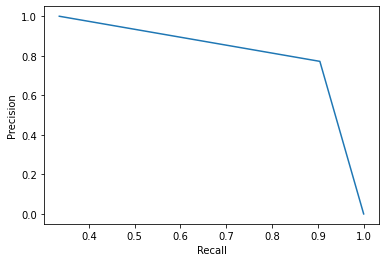

In [143]:
import matplotlib.pyplot as plt 
plt.plot(fpr, tpr)
plt.ylabel("Precision")
plt.xlabel("Recall") 

plt.show()

In [145]:
model.covars_

array([[[2.05167158],
        [0.        ]],

       [[0.37160051],
        [0.46510187]]])

In [185]:
asleep_data = labelled_data[labelled_data['Asleep'] == 0.005]
awake_data = labelled_data[labelled_data['Asleep'] == 0]

In [186]:
asleep_log_steps = np.log(1 + asleep_data['Steps'])
awake_log_steps = np.log(1 + awake_data['Steps'])

In [184]:
labelled_data['Asleep'].max()

0.005

In [148]:
import scipy.stats as stats

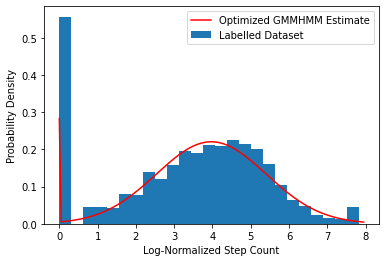

In [189]:
variances = model.covars_[0].flatten()
means = model.means_[0].flatten()
weights = model.weights_[0].flatten()

distr_0 = stats.norm(loc = means[0], scale = variances[0]**0.5+ 0.0001) 
distr_1 = stats.norm(loc = means[1], scale = variances[1] ** 0.5 + 0.0001) 

xs = [0.0004] + [0.05 * x for x in range(1, 160)]

plt.plot(xs, [weights[0] * distr_0.pdf(x) + weights[1] * distr_1.pdf(x) for x in xs], color = "red", label = "Optimized GMMHMM Estimate")

plt.hist(awake_log_steps, bins = 25, density = True, label = "Labelled Dataset")  

plt.xlabel("Log-Normalized Step Count") 
plt.ylabel("Probability Density") 
plt.legend()

# plt.savefig("OptimizedGMMForAwakeEmission.png")

In [190]:
model.get_stationary_distribution()

array([0.70743579, 0.29256421])

In [154]:
weights

array([0.79220449, 0.20779551])

In [156]:
[weights[0] * distr_0.pdf(x) + weights[1] * distr_1.pdf(x) for x in xs]

/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:1740: RuntimeWarning: divide by zero encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)


[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]